# MRF: Markov Random Field

## Setup and Imports

In [16]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [17]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

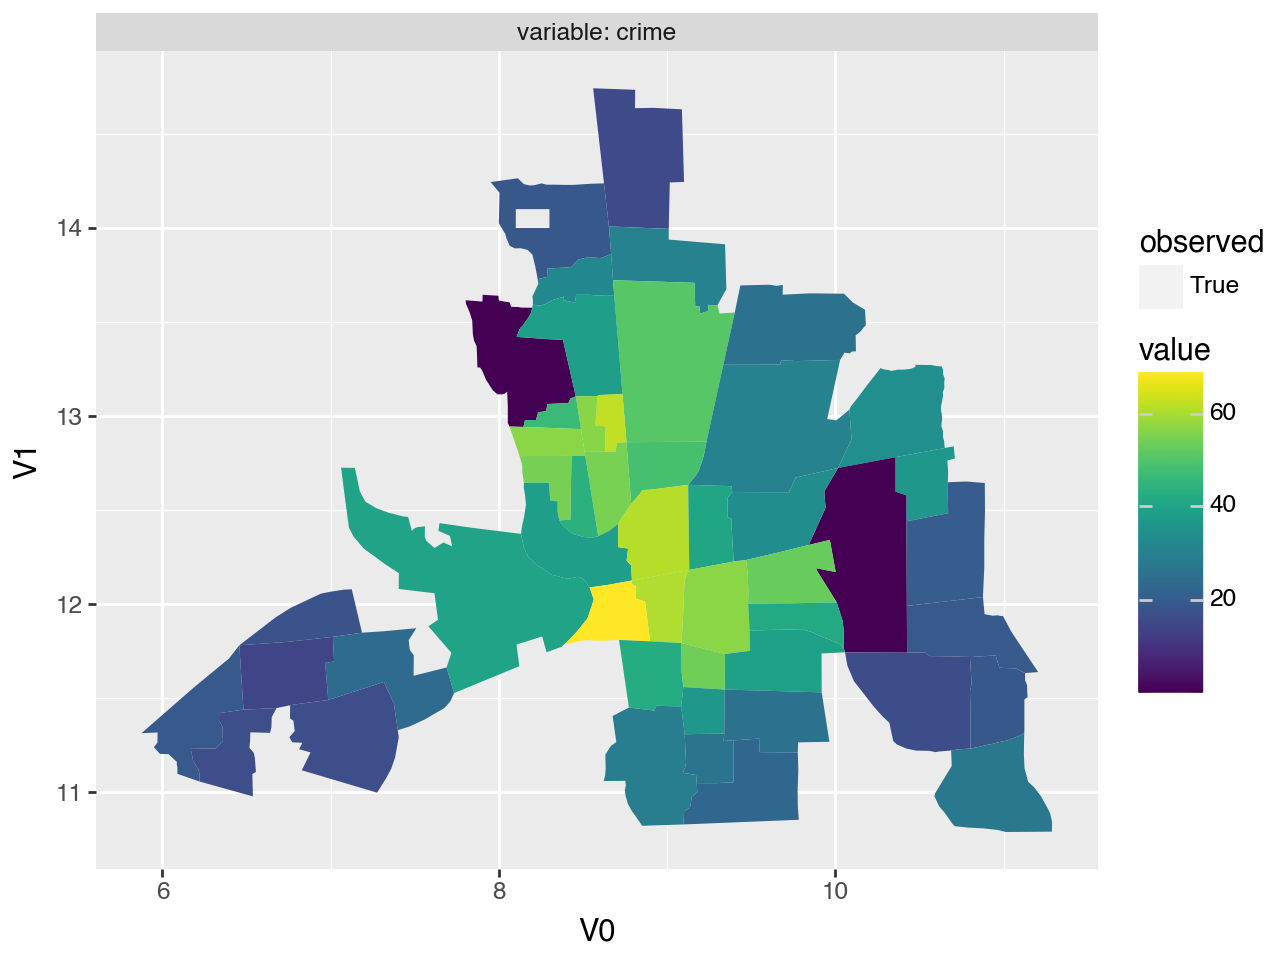

In [18]:
gam.plot_polys(region="district", which=["crime"], df=columb, polys=polys)

## Model Definition

In [ ]:
# removing some observations here to simulate a dataset with unobserved clusters
i = np.arange(columb.shape[0])
i10 = i[:10]
i20 = i[11:20]
i30 = i[21:30]
irest = i[31:]
i = np.concatenate((i10, i20, i30, irest))
df = columb.iloc[i, :].reset_index()

In [ ]:
# standardizing makes it easier for the model
df["crime"] = (df["crime"] - df["crime"].mean()) / df["crime"].std()

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)

# initializing intercepts to sensible values
loc.intercept.value = df.crime.mean()
scale.intercept.value = jnp.log(df.crime.std())


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

tb = gam.TermBuilder.from_df(df)


loc += tb.mrf(
    "district",
    k=40,  # using a low-rank MRF here, because we have only 1 observation per cluster.
    polys=polys,
    scale=gam.VarIGPrior(0.01, 0.01, 0.1),
    factor_scale=True,
)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value
liesel.model.model - INFO - Converted dtype of Value(name="$\beta_{0,\mu}$_value").value


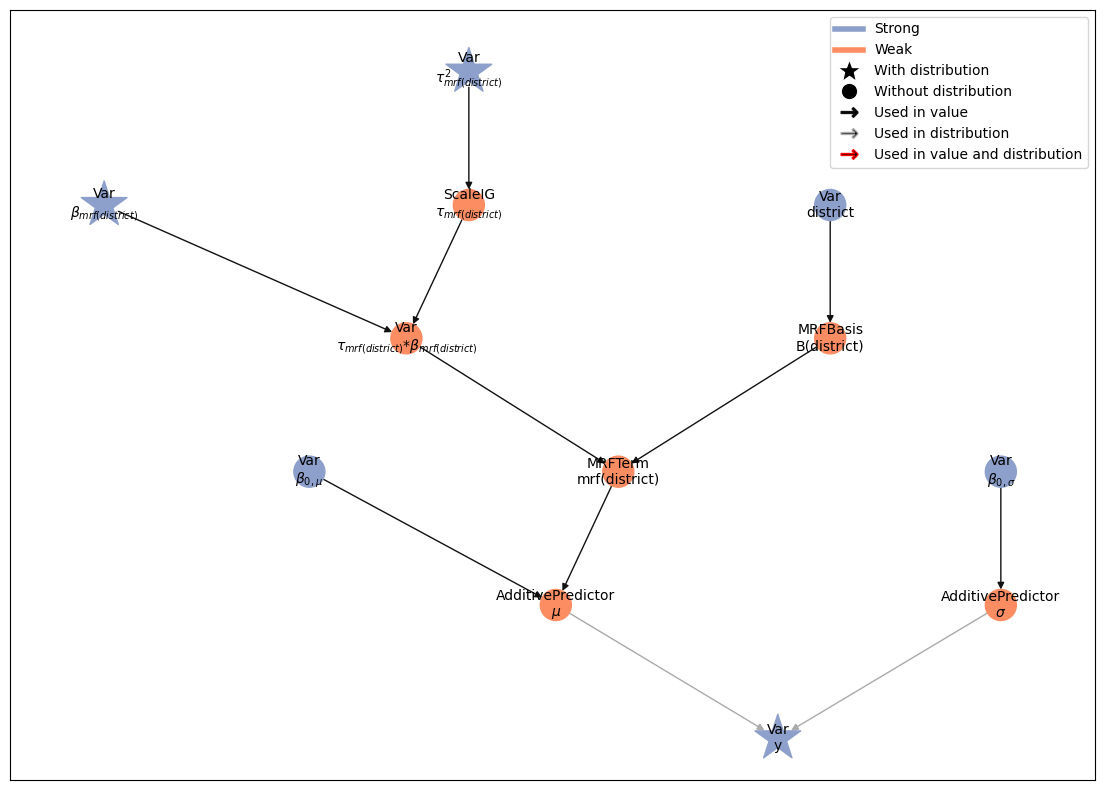

In [21]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [22]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.add_burnin(3000)
eb.add_posterior(10_000, thinning=10)

engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{mrf(district)}$', '$\\tau_{mrf(district)}^2$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: BURNIN, 3000 transitions, 1000 jitted together
100%|██████████████████████████████████████████| 3/3 [00:02<00:00,  1.14chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Finished warmup
liesel.goose.engine - INFO - Starting epoch: POSTERIOR, 10000 transitions, 1000 jitted together
100%|████████████████████████████████████████| 10/10 [00:01<00:00,  8.03chunk/s]
liesel.goose.engine - INFO - Finished epoch


### MCMC summary

In [23]:
summary = gs.Summary(results)
summary

Parameter summary:

                                   kernel      mean        sd    q_0.05  \
parameter                index                                            
$\beta_{0,\mu}$          ()     kernel_01 -0.003580  0.104040 -0.172420   
$\beta_{0,\sigma}$       ()     kernel_00 -0.382368  0.179775 -0.673807   
$\beta_{mrf(district)}$  (0,)   kernel_02  0.734054  0.930112 -0.850236   
                         (1,)   kernel_02  0.183005  0.898392 -1.295767   
                         (2,)   kernel_02 -0.319014  0.896056 -1.772981   
                         (3,)   kernel_02 -0.120443  0.874687 -1.554043   
                         (4,)   kernel_02  0.144608  0.849683 -1.228167   
                         (5,)   kernel_02 -0.048042  0.845411 -1.402315   
                         (6,)   kernel_02  0.890617  0.906810 -0.640480   
                         (7,)   kernel_02 -0.349899  0.863267 -1.741079   
                         (8,)   kernel_02  0.012799  0.827630 -1.373064   
                         (9,)   kernel_02  0.290853  0.850292 -1.128265   
                         (10,)  kernel_02 -0.433604  0.916335 -1.950916   
                         (11,)  kernel_02  0.324850  0.834942 -1.081650   
                         (12,)  kernel_02 -1.306409  0.919171 -2.768893   
                         (13,)  kernel_02  0.151432  0.834099 -1.219404   
                         (14,)  kernel_02 -0.139186  0.850732 -1.538324   
                         (15,)  kernel_02  0.367454  0.836638 -1.012700   
                         (16,)  kernel_02 -0.230954  0.825652 -1.554380   
                         (17,)  kernel_02  0.220780  0.811259 -1.123885   
                         (18,)  kernel_02 -0.330824  0.817928 -1.647253   
                         (19,)  kernel_02  0.539861  0.848227 -0.881640   
                         (20,)  kernel_02 -0.396995  0.812252 -1.682499   
                         (21,)  kernel_02 -0.355798  0.815720 -1.663999   
                         (22,)  kernel_02 -0.112538  0.819784 -1.451739   
                         (23,)  kernel_02 -0.573999  0.796707 -1.840591   
                         (24,)  kernel_02 -0.452299  0.791887 -1.775378   
                         (25,)  kernel_02  0.374664  0.814586 -0.958073   
                         (26,)  kernel_02 -0.401156  0.759131 -1.618902   
                         (27,)  kernel_02  0.644882  0.760511 -0.639059   
                         (28,)  kernel_02  0.230367  0.859052 -1.198759   
                         (29,)  kernel_02 -0.158961  0.798545 -1.459488   
                         (30,)  kernel_02 -0.756595  0.703527 -1.866371   
                         (31,)  kernel_02 -1.012188  0.687997 -2.131813   
                         (32,)  kernel_02  0.751591  0.665425 -0.370213   
                         (33,)  kernel_02 -1.241534  0.719319 -2.386984   
                         (34,)  kernel_02  0.679548  0.594236 -0.288307   
                         (35,)  kernel_02  1.364089  0.533356  0.519688   
                         (36,)  kernel_02 -1.444965  0.516227 -2.334677   
                         (37,)  kernel_02  0.380117  0.380897 -0.214342   
                         (38,)  kernel_02 -0.634658  0.320186 -1.233288   
$\tau_{mrf(district)}^2$ ()     kernel_03  3.475489  1.868635  0.896338   

                                   q_0.5    q_0.95  sample_size     ess_bulk  \
parameter                index                                                 
$\beta_{0,\mu}$          ()    -0.003226  0.168574         4000  4128.141289   
$\beta_{0,\sigma}$       ()    -0.387672 -0.078226         4000   759.769426   
$\beta_{mrf(district)}$  (0,)   0.757395  2.223578         4000  2224.144217   
                         (1,)   0.181252  1.641307         4000  3331.498057   
                         (2,)  -0.340988  1.181685         4000  3096.563629   
                         (3,)  -0.111225  1.336551         4000  3651.294647   
                         (4,)   0.14342

## Plots

In [24]:
samples = results.get_posterior_samples()

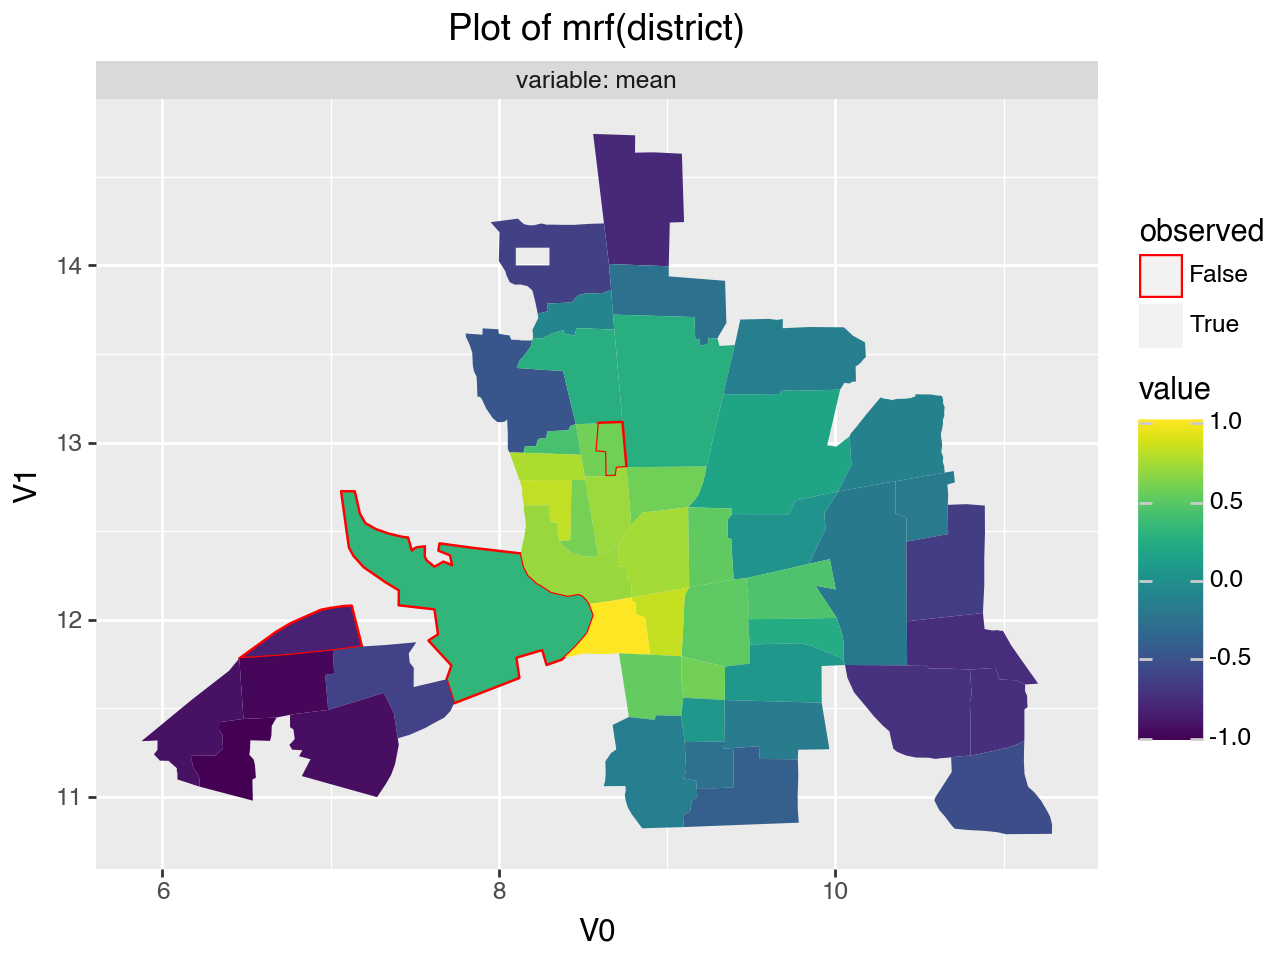

In [25]:
gam.plot_regions(term=loc.terms["mrf(district)"], samples=samples, polys=polys)

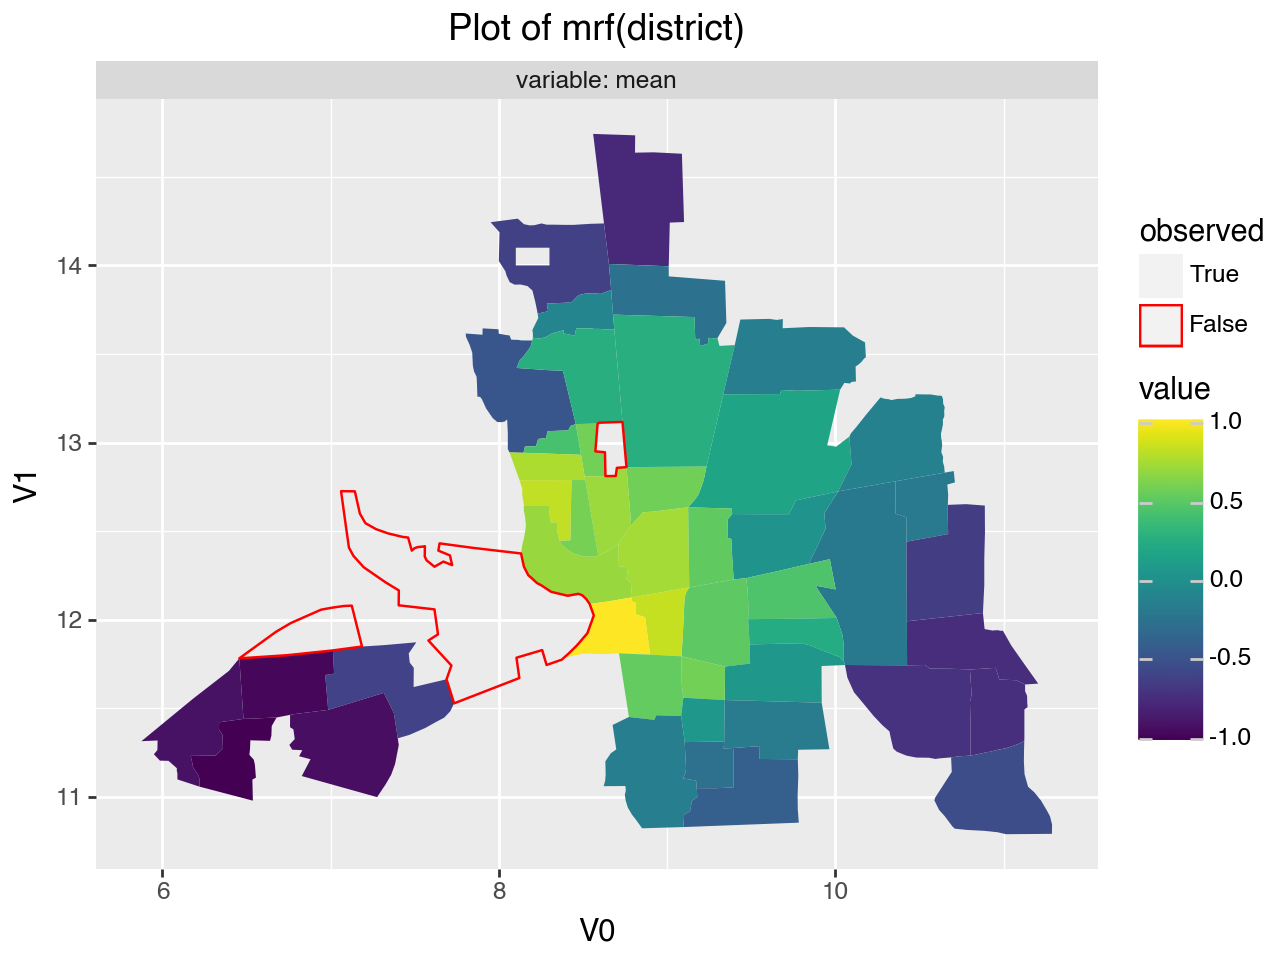

In [26]:
gam.plot_regions(
    term=loc.terms["mrf(district)"],
    samples=samples,
    polys=polys,
    show_unobserved=False,
    unobserved_color="red",
    observed_color="none",
)

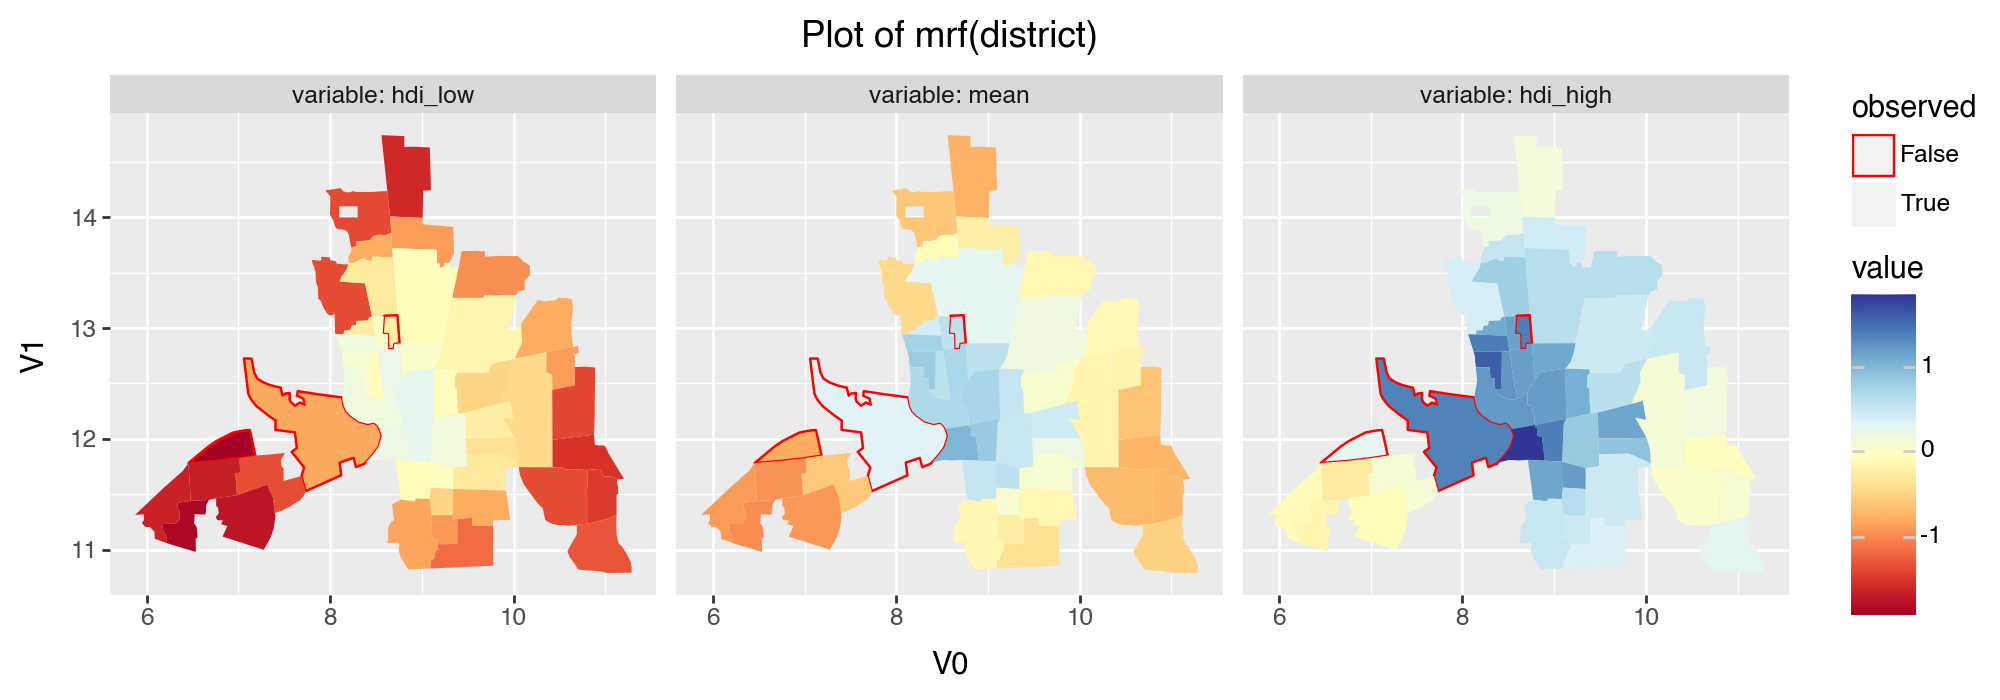

In [27]:
import plotnine as p9

(
    gam.plot_regions(
        term=loc.terms["mrf(district)"],
        samples=samples,
        polys=polys,
        which=["hdi_low", "mean", "hdi_high"],
        observed_color="none",
        unobserved_color="red",
        # show_unobserved=False
    )
    + p9.theme(figure_size=(10, 3.5))
    + p9.scale_fill_cmap("RdYlBu")
)

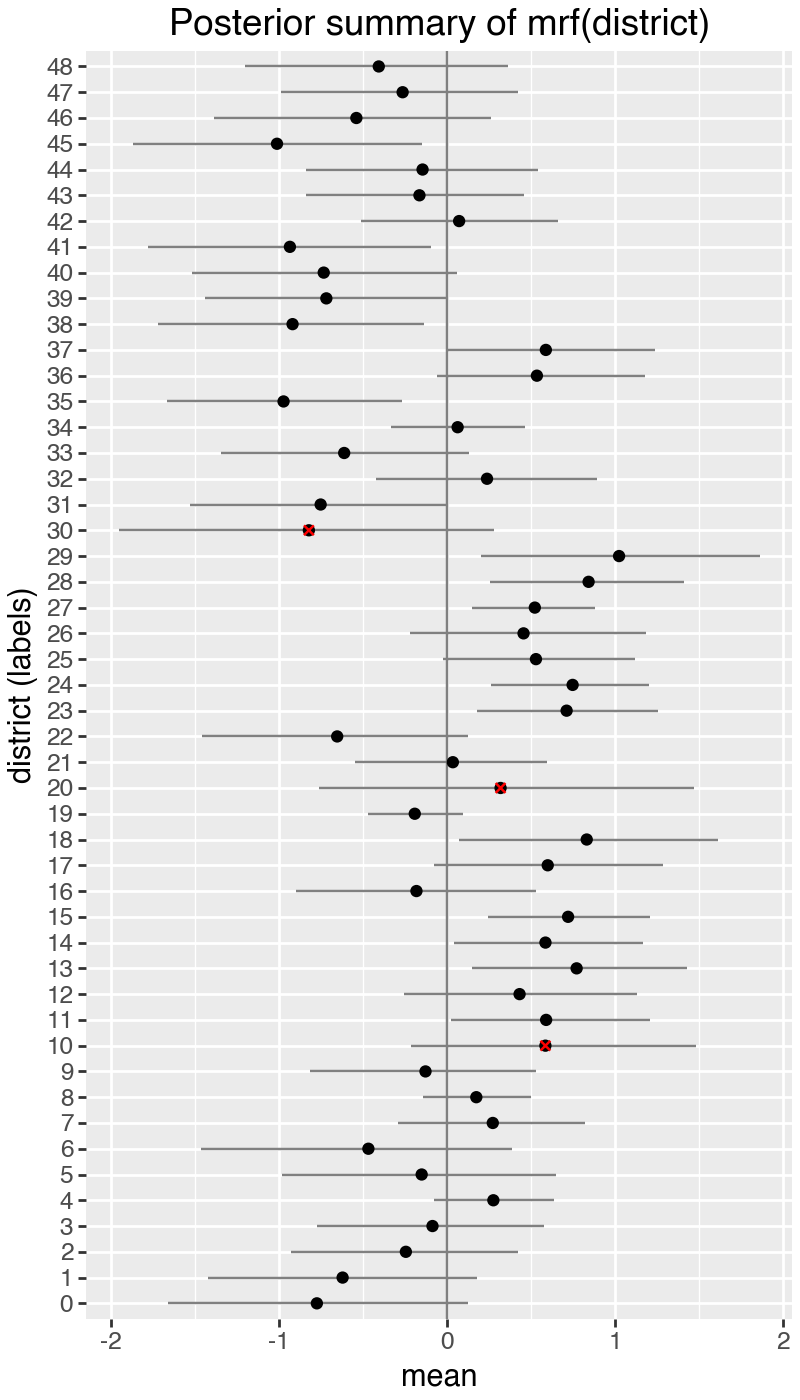

In [28]:
gam.plot_forest(
    term=loc.terms["mrf(district)"],
    samples=samples,
    ymin="q_0.05",
    ymax="q_0.95",
    show_unobserved=True,
) + p9.theme(figure_size=(4, 7))